In [2]:
import cv2
import numpy as np
from numpy.linalg import *
import open3d as o3d
import matplotlib.pyplot as plt
import scipy
import scipy.sparse
import scipy.sparse.linalg

image_row = 0 
image_col = 0

# visualizing the mask (size : "image width" * "image height")
def mask_visualization(M):
    mask = np.copy(np.reshape(M, (image_row, image_col)))
    plt.figure()
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

# visualizing the unit normal vector in RGB color space
# N is the normal map which contains the "unit normal vector" of all pixels (size : "image width" * "image height" * 3)
def normal_visualization(N):
    # converting the array shape to (w*h) * 3 , every row is a normal vetor of one pixel
    N_map = np.copy(np.reshape(N, (image_row, image_col, 3)))
    # Rescale to [0,1] float number
    N_map = (N_map + 1.0) / 2.0
    plt.figure()
    plt.imshow(N_map)
    plt.title('Normal map')

# visualizing the depth on 2D image
# D is the depth map which contains "only the z value" of all pixels (size : "image width" * "image height")
def depth_visualization(D):
    D_map = np.copy(np.reshape(D, (image_row,image_col)))
    # D = np.uint8(D)
    plt.figure()
    plt.imshow(D_map)
    plt.colorbar(label='Distance to Camera')
    plt.title('Depth map')
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')

# convert depth map to point cloud and save it to ply file
# Z is the depth map which contains "only the z value" of all pixels (size : "image width" * "image height")
def save_ply(Z,filepath):
    filepath = f"./report/{filepath}/{filepath}.ply"
    Z_map = np.reshape(Z, (image_row,image_col)).copy()
    data = np.zeros((image_row*image_col,3),dtype=np.float32)
    # let all point float on a base plane 
    baseline_val = np.min(Z_map)
    Z_map[np.where(Z_map == 0)] = baseline_val
    for i in range(image_row):
        for j in range(image_col):
            idx = i * image_col + j
            data[idx][0] = j
            data[idx][1] = i
            data[idx][2] = Z_map[image_row - 1 - i][j]
    # output to ply file
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(data)
    o3d.io.write_point_cloud(filepath, pcd,write_ascii=True)

# show the result of saved ply file
def show_ply(filepath):
    filepath = f"./report/{filepath}/{filepath}.ply"
    pcd = o3d.io.read_point_cloud(filepath)
    o3d.visualization.draw_geometries([pcd])

# read the .bmp file
def read_bmp(filepath):
    global image_row
    global image_col
    image = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
    image_row , image_col = image.shape
    return image


# if __name__ == '__main__':
#     # showing the windows of all visualization function
#     plt.show()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


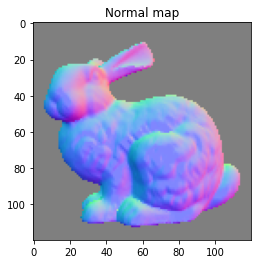

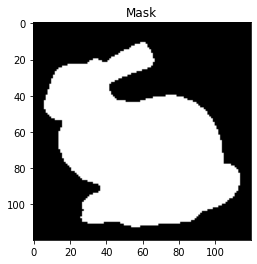

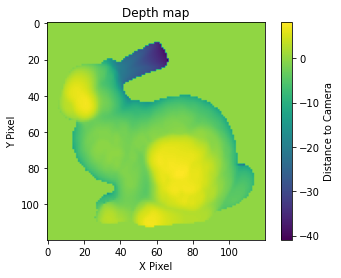

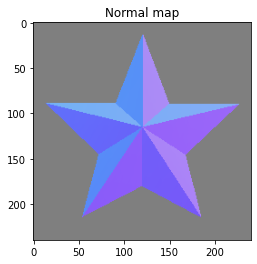

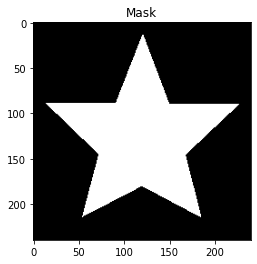

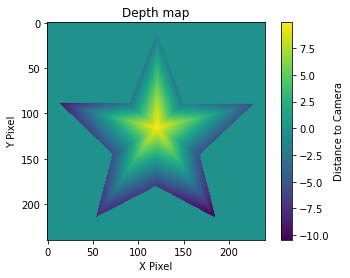

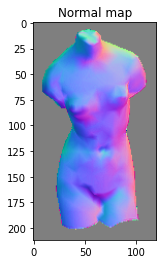

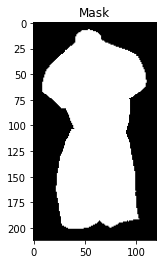

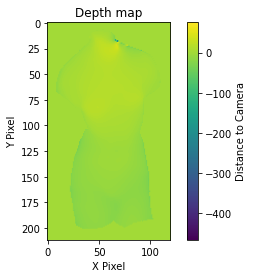

In [91]:
class photometric_stereo:
    def __init__(self, pic, num_image, venus = 0 ):
        self.pic = pic
        self.num_image = num_image
        self.I = None
        self.L = None
        self.Kdn = None
        self.mask = None
        self.M = None
        self.z = None
        self.V = None
        self.venus = venus

    def get_image(self): # for matrix I
        for i in range(1,self.num_image+1):
            row = np.array(read_bmp(f"./test/{self.pic}/pic{i}.bmp").reshape(1,-1))
            if i != 1 :
                image = np.vstack((image,row))
            else:
                image = row
        self.I = np.array(image)
        
    def get_light_source(self): # for matrix L
        with open(f"./test/{self.pic}/LightSource.txt") as f:
            lines = f.readlines()
        for i in range(self.num_image):
            start = lines[i].find("(")
            end = lines[i].find(")")
            comma = lines[i].find(",")
            rcomma = lines[i].rfind(',')
            lx = int(lines[i][start+1:comma])
            ly = int(lines[i][comma+1:rcomma])
            lz = int(lines[i][rcomma+1:end])

            row = np.array([lx, ly, lz])
            row = row / np.linalg.norm(row)
            if i != 0 :
                light = np.vstack((light,row))
            else:
                light = row

        self.L = np.array(light)
        
    def compute_Kdn(self):
        # I = L * KdN
        # L * KdN = I
        # KdN = (L)^-1 * L^T * I
        #self.Kdn = np.linalg.pinv((self.L).T @ self.L) @ (self.L).T @ self.I
        self.Kdn = np.linalg.pinv(self.L) @ self.I
        self.Kdn = self.Kdn.T

        for i in range(len(self.Kdn)):
            self.Kdn[i] = self.Kdn[i] / (np.linalg.norm(self.Kdn[i]) +1e-13)

    def get_mask(self):
        image = np.array(read_bmp(f"./test/{self.pic}/pic{1}.bmp"))
        self.mask = np.array(image)
        self.mask[self.mask > 0] = 1

    def compute_depth(self):
        # Mz = V
        # M shape(2*numpixel, numpixel)
        # z shape(numpixel, 1)
        # V shape(2*numpixel, 1)

        im_h, im_w = (self.mask).shape
        N_map = np.reshape(self.Kdn, (im_h, im_w, 3))
        
        obj_h, obj_w = np.where(self.mask != 0)

        num_pix = np.size(obj_h)

        full2obj = np.zeros((im_h, im_w))
        for idx in range(np.size(obj_h)):
            full2obj[obj_h[idx], obj_w[idx]] = idx

        self.M = scipy.sparse.lil_matrix((2*num_pix, num_pix))
        self.V = np.zeros((2*num_pix, 1))

        for idx in range(num_pix):
            h = obj_h[idx]
            w = obj_w[idx]

            n_x = N_map[h, w, 0]
            n_y = N_map[h, w, 1]
            n_z = N_map[h, w, 2]

            # z_(x+1, y) - z(x, y) = -nx / nz
            row_idx = idx * 2
            if self.mask[h, w+1]:
                idx_horiz = full2obj[h, w+1]
                self.M[row_idx, idx] = -1
                self.M[row_idx, int(idx_horiz)] = 1
                if n_z == 0 :
                    self.V[row_idx] = 0
                else:    
                    self.V[row_idx] = -n_x / n_z

            elif self.mask[h, w-1]:
                idx_horiz = full2obj[h, w-1]
                self.M[row_idx, int(idx_horiz)] = -1
                self.M[row_idx, idx] = 1
                if n_z == 0 :
                    self.V[row_idx] = 0
                else:    
                    self.V[row_idx] = -n_x / n_z
            # z_(x, y+1) - z(x, y) = -ny / nz
            row_idx = idx * 2 + 1
            if self.mask[h+1, w]:
                idx_vert = full2obj[h+1, w]
                self.M[row_idx, idx] = 1
                self.M[row_idx, int(idx_vert)] = -1
                if n_z == 0 :
                    self.V[row_idx] = 0
                else:    
                    self.V[row_idx] = -n_y / n_z

                
            elif self.mask[h-1, w]:
                idx_vert = full2obj[h-1, w]
                self.M[row_idx, int(idx_vert)] = 1
                self.M[row_idx, idx] = -1
                if n_z == 0 :
                    self.V[row_idx] = 0
                else:    
                    self.V[row_idx] = -n_y / n_z
                    
        MtM = (self.M).T @ self.M
        MtV = (self.M).T @ self.V

        z = scipy.sparse.linalg.spsolve(MtM, MtV)
        self.z = z
        
        if self.venus:
            std_z = np.std(z, ddof=1)
            mean_z = np.mean(z)
            z_zscore = (z - mean_z) / std_z

            outlier_ind = np.abs(z_zscore) > 5
            #print(outlier_ind)
            z_min = np.min(z[~outlier_ind])
            z_max = np.max(z[~outlier_ind])

        self.z = self.mask.astype('float')
        for idx in range(num_pix):
            h = obj_h[idx]
            w = obj_w[idx]
            if self.venus:
                self.z[h, w] = (z[idx] - z_min) / (z_max - z_min) * 255
            else:
                self.z[h, w] = z[idx]
        
        # self.z[self.z==0] = self.z[self.z==0] + mean_z
        # self.z[self.z < mean_z] = mean_z
        if self.venus:
            for i in range(1):
                mean_z = np.mean(self.z)
                #self.z[self.z==0] = self.z[self.z==0] + mean_z
                self.z[self.z < (mean_z-20)] = mean_z-20
                self.z[self.z > (mean_z+170)] = mean_z+170
                

    def visualization(self):
        normal_visualization(self.Kdn)
        mask_visualization(self.mask)
        depth_visualization(self.z)
        

    def run(self):
        self.get_image()
        self.get_light_source()
        self.compute_Kdn()
        self.get_mask()
        self.compute_depth()
        self.visualization()

num = 6

np.set_printoptions(threshold=np.inf)
bunny = photometric_stereo("bunny",num)
bunny.run()

save_ply(bunny.z,"bunny")
show_ply("bunny")

star = photometric_stereo("star",num)
star.run()

save_ply(star.z,"star")
show_ply("star")

venus = photometric_stereo("venus",num,venus=1)
venus.run()

save_ply(venus.z,"venus")
show_ply("venus")
